# Klasifikasi Stress EEG dengan Seleksi Channel

In [1]:
import os
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras  # Impor keras untuk model CNN

# Impor file-file Python Anda
import variables as v
import dataset
import features
import classifiers
import genetic_algrthm as ga

In [2]:
PATH_DATA_MENTAH = "Data/raw_data"
PATH_FILE_LOCS = v.CHANNELS_PATH
PATH_FILE_LABEL = v.LABELS_PATH

In [3]:
# Memuat data mentah dari semua 32 channel
full_dataset = dataset.load_dataset(data_type="raw", test_type="Arithmetic")
# Memuat daftar nama dari 32 channel tersebut dari file .locs
all_channels_list = dataset.load_channels()
print(f"Berhasil memuat dataset dengan {full_dataset.shape[1]} channel.")
print(f"Bentuk data: {full_dataset.shape}")
print(f"Daftar channel yang dimuat: {all_channels_list}")

Berhasil memuat dataset dengan 32 channel.
Bentuk data: (120, 32, 3200)
Daftar channel yang dimuat: ['Cz', 'Fz', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'Pz', 'Oz', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']


## Channel Selection

In [4]:
# Pengaturan untuk Algoritma Genetika
ga_parameters = {
    "num_generations": 10,
    "num_parents_mating": 5,
    "num_people_in_pop": 15,
    "num_channels_to_select": 8
}

# Mempersiapkan label yang dibutuhkan
raw_labels_df = dataset.load_labels()
# Asumsi 12 epoch per trial berdasarkan data Anda
num_epochs_per_trial = 12
labels_for_ga = dataset.format_labels(
    raw_labels_df, test_type="Arithmetic", epochs=num_epochs_per_trial)

print("\n--- Langkah 2: Menjalankan Algoritma Genetika untuk Seleksi Channel ---")
# Menjalankan seluruh proses dengan satu panggilan fungsi
selected_channels = ga.run_channel_selection(
    full_dataset=full_dataset,
    all_channels_list=all_channels_list,
    labels_for_ga=labels_for_ga,
    ga_params=ga_parameters
)


--- Langkah 2: Menjalankan Algoritma Genetika untuk Seleksi Channel ---
  -> Generasi 1/10...
     -> Ditemukan solusi terbaik baru dengan fitness 2.22
     -> Channel: ['C3' 'CP5' 'FT9' 'C4' 'F8' 'Pz' 'PO9' 'O2']
  -> Generasi 2/10...
     -> Ditemukan solusi terbaik baru dengan fitness 2.27
     -> Channel: ['Fp2' 'CP5' 'O2' 'Oz' 'F3' 'Pz' 'CP2' 'CP6']
  -> Generasi 3/10...
  -> Generasi 4/10...
  -> Generasi 5/10...
  -> Generasi 6/10...
  -> Generasi 7/10...
  -> Generasi 8/10...
  -> Generasi 9/10...
  -> Generasi 10/10...

--- Seleksi Channel Selesai ---
Channel terbaik yang ditemukan: ['Fp2', 'CP5', 'O2', 'Oz', 'F3', 'Pz', 'CP2', 'CP6']


In [5]:
# Filter dataset untuk hanya menyertakan channel yang terpilih
Data = ga.get_subset(
    data=full_dataset,
    all_genes=all_channels_list,
    subset_genes=selected_channels
)

print(f"\nChannel yang terpilih: {selected_channels}")
print(f"Bentuk data setelah seleksi channel: {Data.shape}")


Channel yang terpilih: ['Fp2', 'CP5', 'O2', 'Oz', 'F3', 'Pz', 'CP2', 'CP6']
Bentuk data setelah seleksi channel: (120, 8, 3200)


Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Using matplotlib as 2D backend.


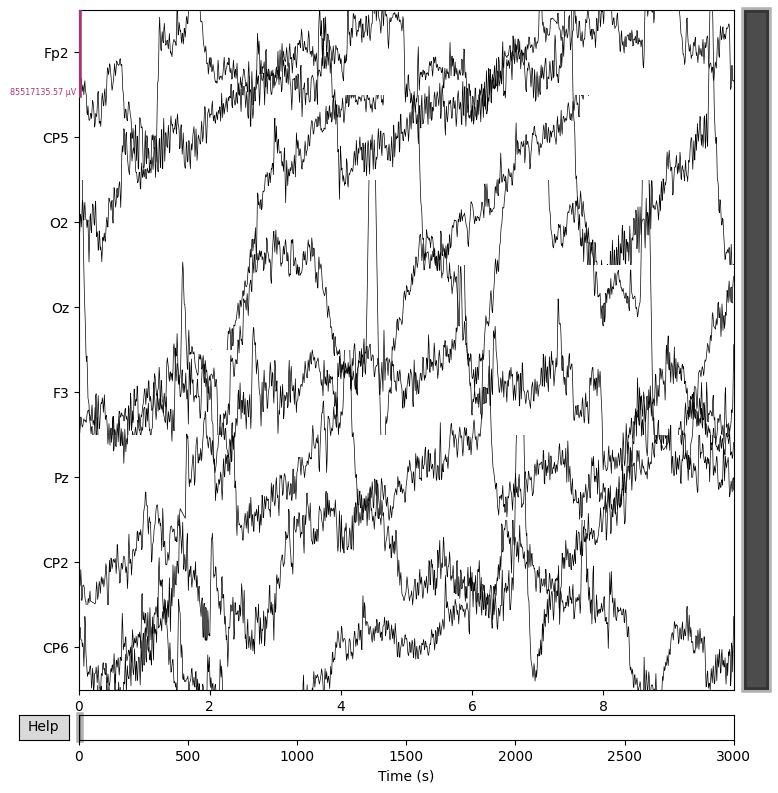

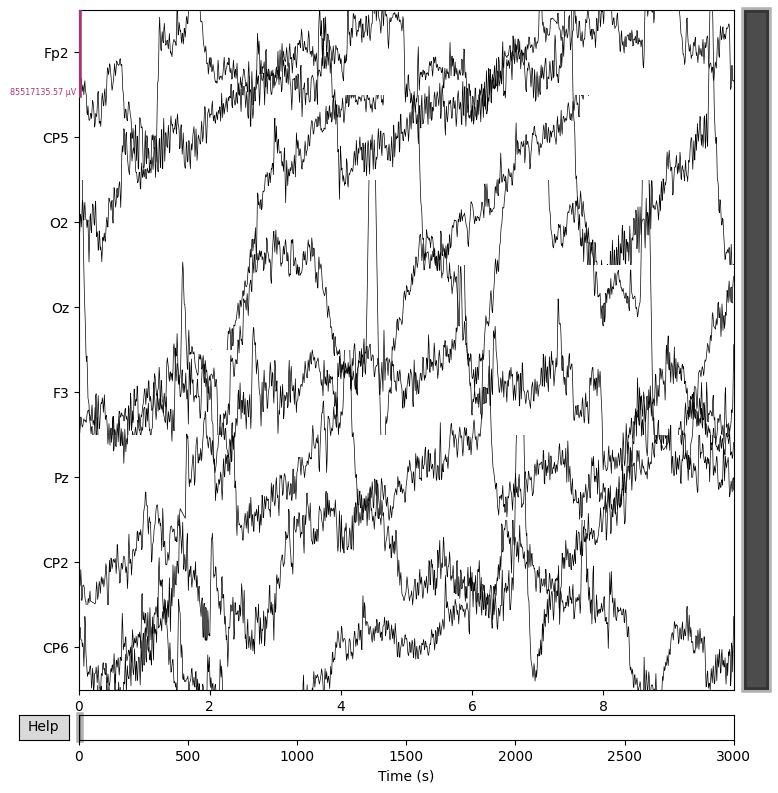

In [6]:
n_trials, n_channels, n_samples_per_trial = Data.shape
visdata = Data.reshape(n_channels, n_trials * n_samples_per_trial)

ch_names = selected_channels
ch_types = ['eeg'] * n_channels
sfreq = v.SFREQ  # Ambil frekuensi sampling dari file variables.py

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# 3. Buat objek MNE RawArray dari data NumPy dan Info
mne_object = mne.io.RawArray(visdata, info)

# 4. Plot sinyal menggunakan fungsi bawaan MNE
#    'n_channels' -> berapa channel yang ditampilkan sekaligus
#    'duration' -> berapa detik data yang ditampilkan per layar
#    'scalings' -> mengatur skala plot agar sinyal terlihat jelas
mne_object.plot(n_channels=8, duration=10, scalings='auto')

In [7]:
all_types_to_load = v.TRIAL_TYPES + v.BASELINE_TYPE

mne_objects_dict = {}

for data_type in all_types_to_load:
    temp_full_dataset = dataset.load_dataset(
        data_type = 'raw', test_type=data_type)
    temp_channels_selection = ga.get_subset(
        data=temp_full_dataset,
        all_genes=all_channels_list,
        subset_genes=selected_channels
    )

    n_trials, n_channels, n_samples = temp_channels_selection.shape
    data_for_mne = temp_channels_selection.reshape(
        n_channels, n_trials * n_samples)
    
    info = mne.create_info(
        ch_names=selected_channels,
        sfreq=v.SFREQ,
        ch_types=['eeg'] * len(selected_channels)
        )
    
    mne_objects_dict[data_type] = mne.io.RawArray(data_for_mne, info)

print(f'{len(mne_objects_dict)} jenis data telah dimuat ke dalam dictionary mne_objects_dict.')


    

Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=384000
    Range : 0 ... 383999 =      0.000 ...  2999.992 secs
Ready.
4 jenis data telah dimuat ke dalam dictionary mne_objects_dict.


## Decomposed Data & Differential Entropy


In [8]:
decomposed_data = features.decompose_to_bands(mne_objects_dict)

de_features = features.differential_entropy_features(decomposed_data)
if de_features:
    print(
        f"Task yang berhasil diekstrak fiturnya: {list(de_features.keys())}")
    first_key = list(de_features.keys())[0]
    print(
        f"Bentuk vektor fitur untuk '{first_key}': {de_features[first_key].shape}")

Task yang berhasil diekstrak fiturnya: ['Arithmetic', 'Mirror', 'Stroop']
Bentuk vektor fitur untuk 'Arithmetic': (32,)


Menampilkan visualisasi sinyal per band untuk task: Arithmetic

--- Visualisasi untuk Band: Theta ---


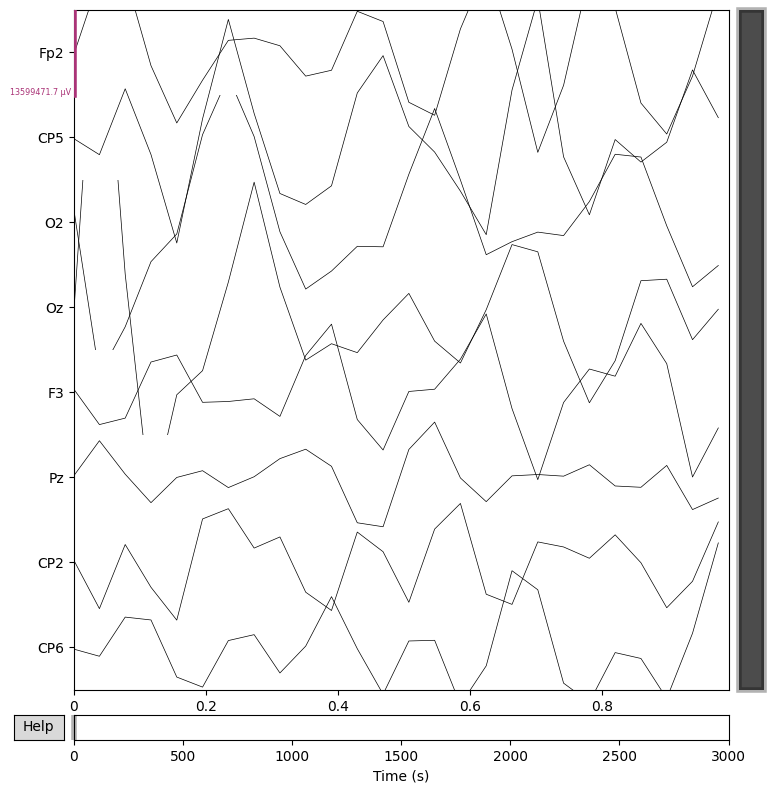


--- Visualisasi untuk Band: Alpha ---


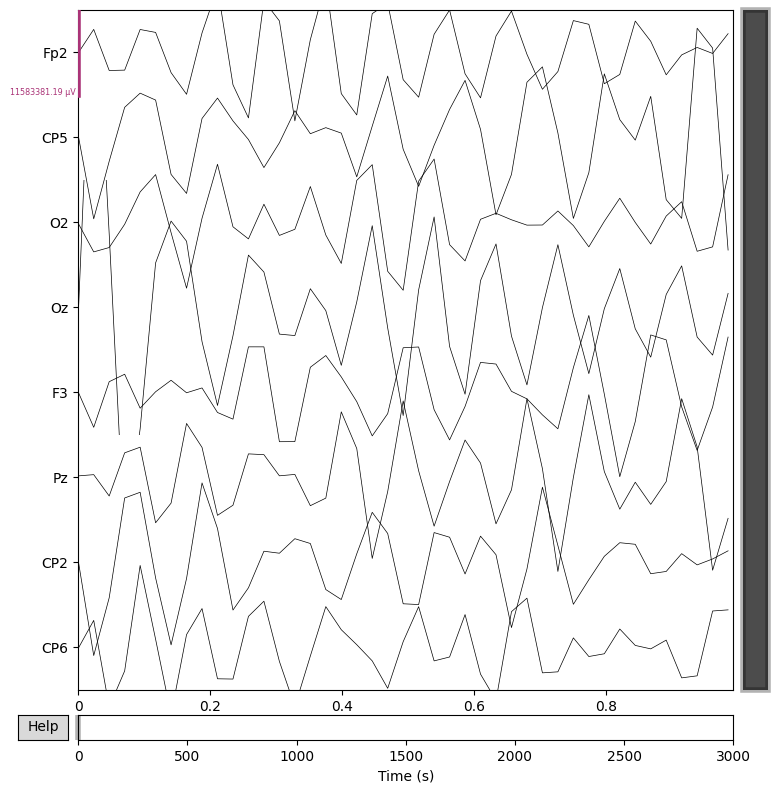


--- Visualisasi untuk Band: Beta ---


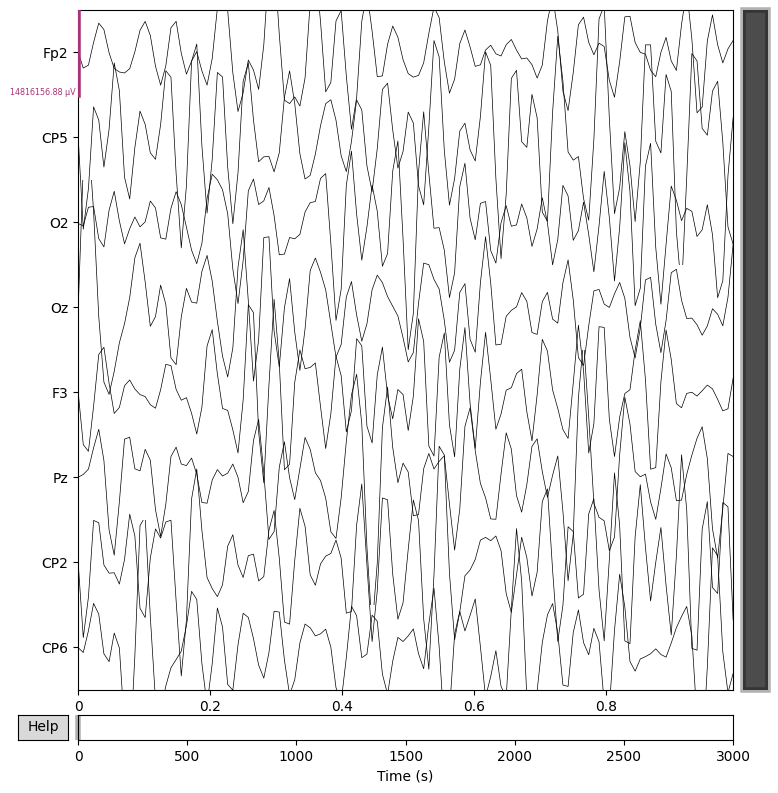


--- Visualisasi untuk Band: Gamma ---


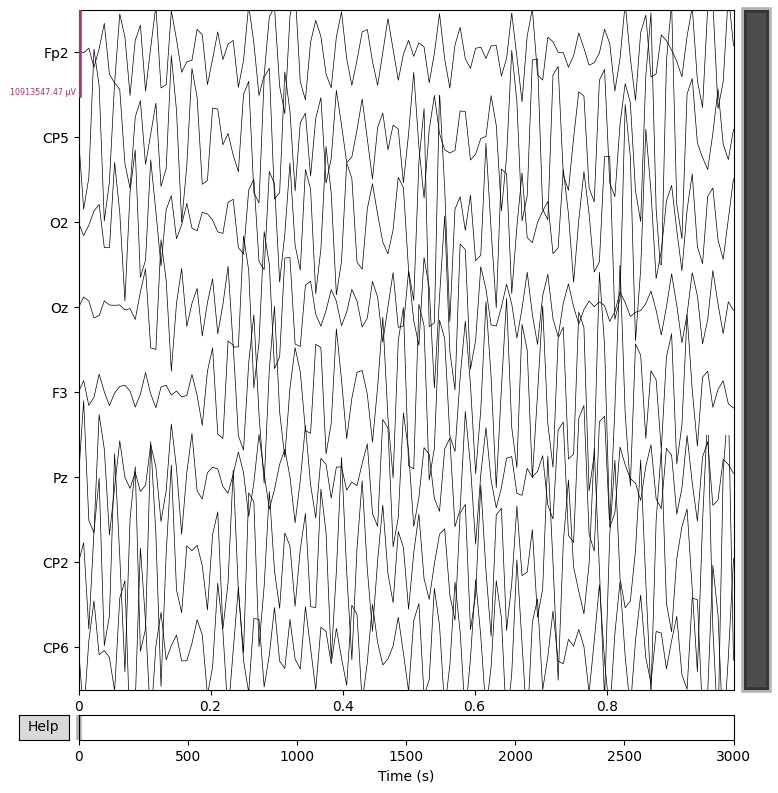

In [9]:
# Tentukan task mana yang ingin Anda lihat visualisasinya
task_to_visualize = 'Arithmetic'
# Tentukan urutan band
band_order = ['Theta', 'Alpha', 'Beta', 'Gamma']

print(
    f"Menampilkan visualisasi sinyal per band untuk task: {task_to_visualize}")

# Loop untuk setiap nama band
for band_name in band_order:
    print(f"\n--- Visualisasi untuk Band: {band_name} ---")

    # 1. Akses objek MNE untuk task dan band yang spesifik
    mne_band_object = decomposed_data[task_to_visualize][band_name]

    # 2. Panggil fungsi .plot() pada objek tersebut
    #    Plot akan muncul satu per satu untuk setiap band
    mne_band_object.plot(n_channels=8, duration=1, scalings='auto')

## 3D Cube


--- DEBUGGING UNTUK TASK: Arithmetic ---
  Jumlah channel valid yang ditemukan di file .locs: 8
  Nama channel valid (disortir): ['CP2', 'CP5', 'CP6', 'F3', 'Fp2', 'O2', 'Oz', 'Pz']
  Jumlah titik koordinat (points): 8
    -> Memproses Band 'Theta':
       Jumlah 'values' (nilai fitur): 8
    -> Memproses Band 'Alpha':
       Jumlah 'values' (nilai fitur): 8
    -> Memproses Band 'Beta':
       Jumlah 'values' (nilai fitur): 8
    -> Memproses Band 'Gamma':
       Jumlah 'values' (nilai fitur): 8

--- DEBUGGING UNTUK TASK: Mirror ---
  Jumlah channel valid yang ditemukan di file .locs: 8
  Nama channel valid (disortir): ['CP2', 'CP5', 'CP6', 'F3', 'Fp2', 'O2', 'Oz', 'Pz']
  Jumlah titik koordinat (points): 8
    -> Memproses Band 'Theta':
       Jumlah 'values' (nilai fitur): 8
    -> Memproses Band 'Alpha':
       Jumlah 'values' (nilai fitur): 8
    -> Memproses Band 'Beta':
       Jumlah 'values' (nilai fitur): 8
    -> Memproses Band 'Gamma':
       Jumlah 'values' (nilai fitur): 

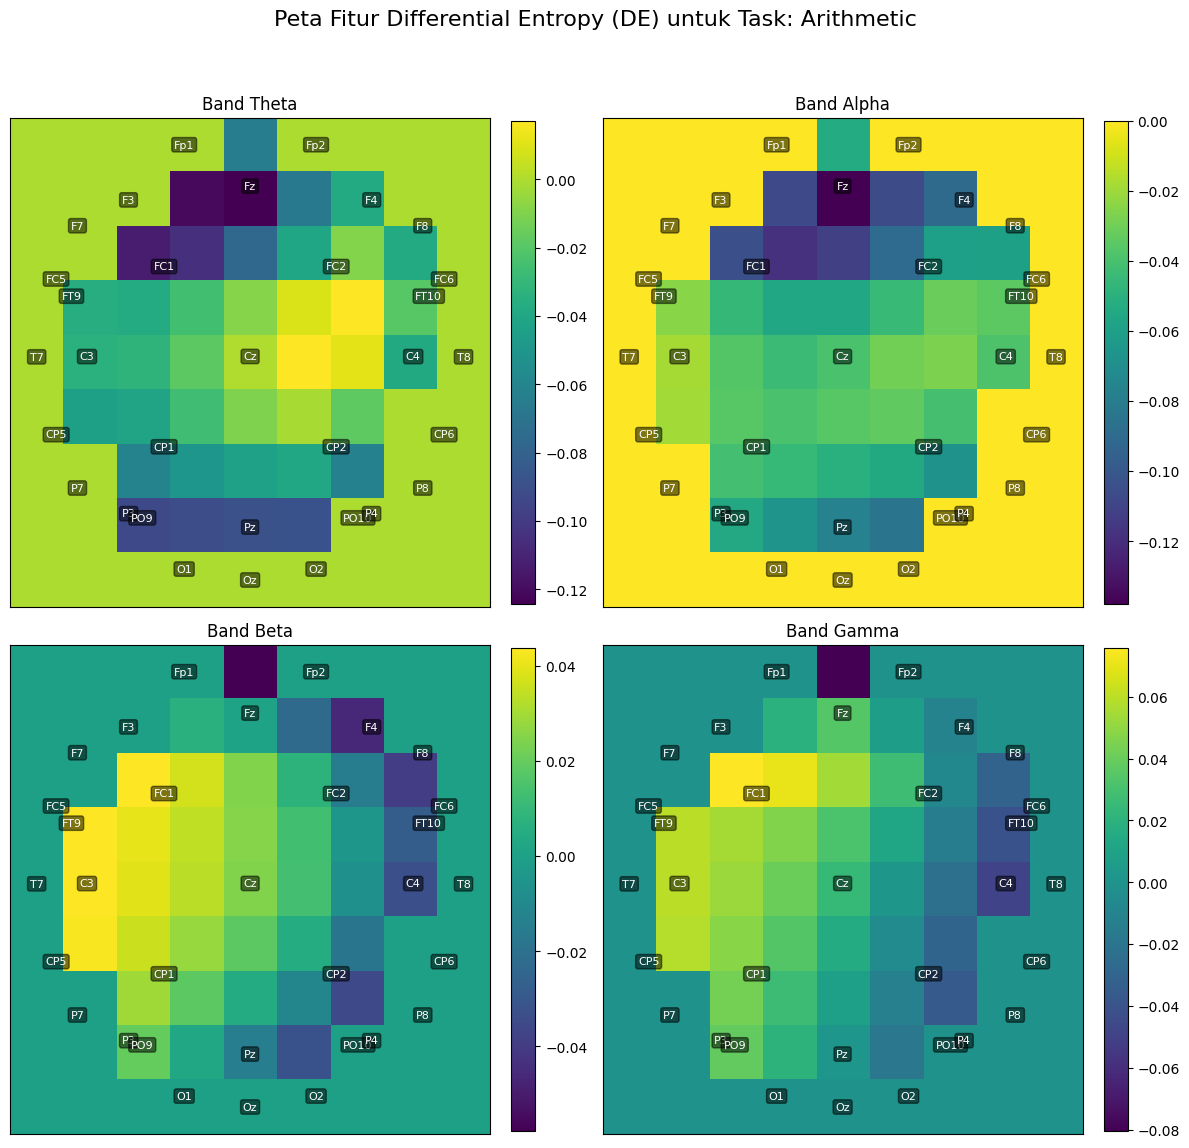

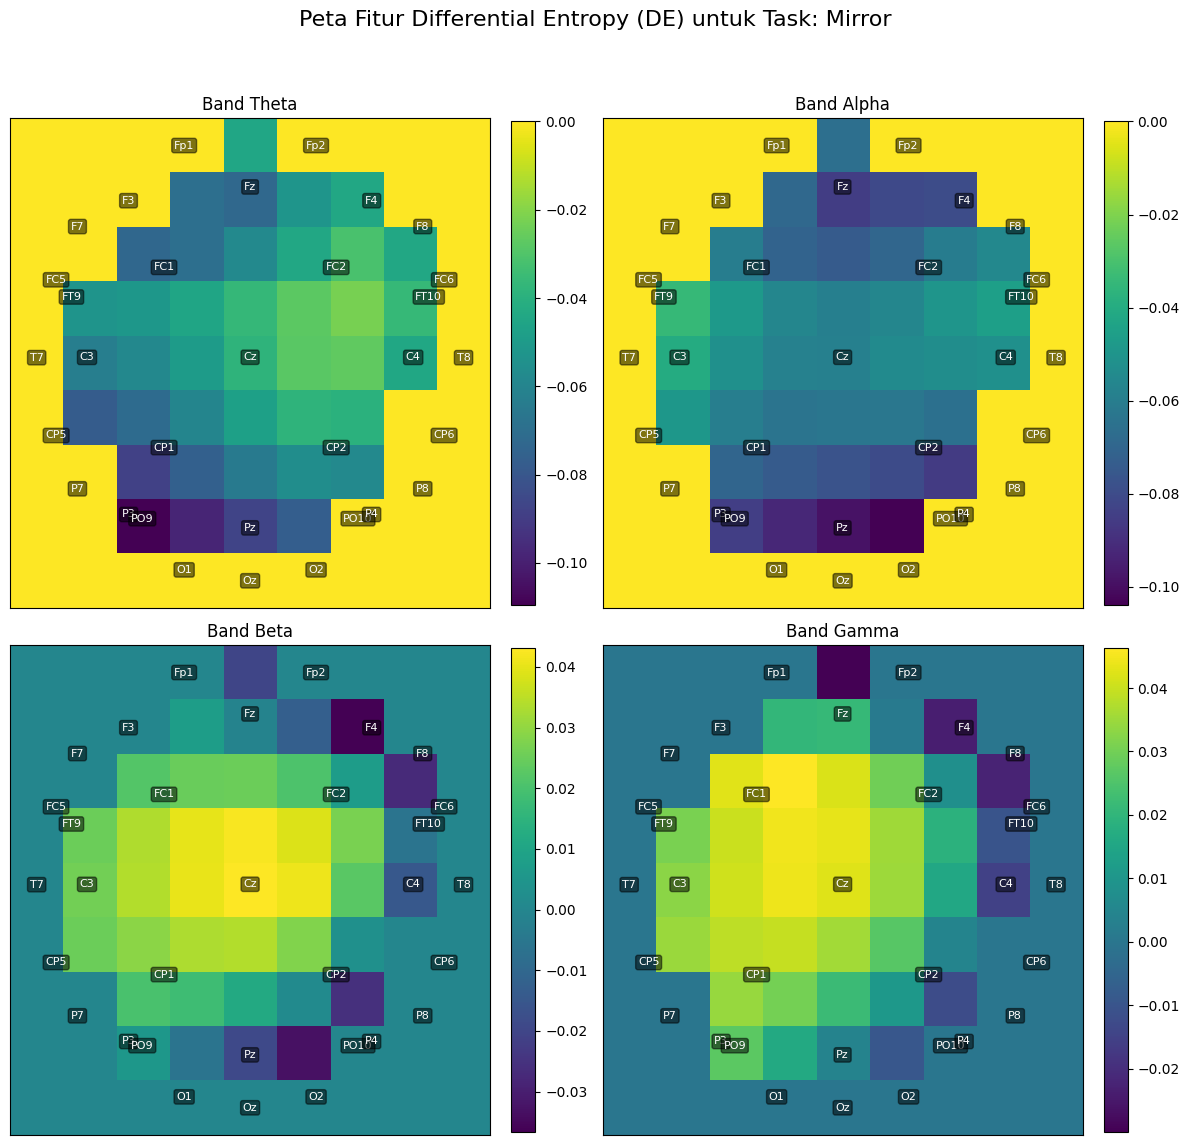

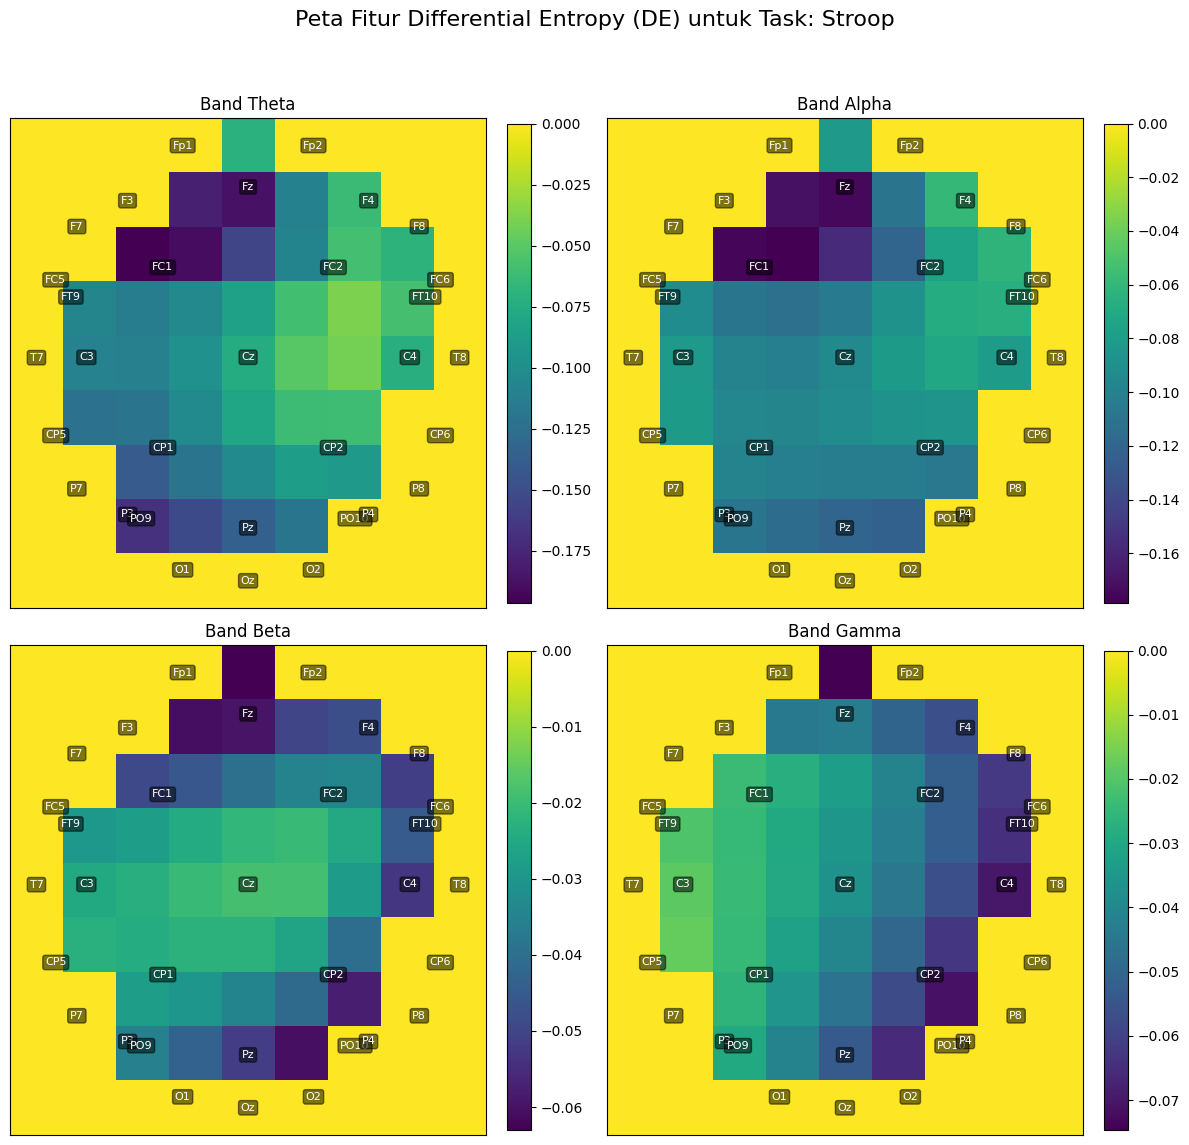

In [11]:
feature_maps_3d = features.create_3d_feature_maps(
    feature_vectors_dict=de_features,
    montage_path=v.CHANNELS_PATH,
    selected_channels_list=selected_channels
    )

for task_name, feature_map in feature_maps_3d.items():
    features.visualize_3d_feature_map(
        feature_map,
        montage_path=v.CHANNELS_PATH,
        title=f"Peta Fitur Differential Entropy (DE) untuk Task: {task_name}"
    )